In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import tensorflow as tf

import sys
sys.path.append('../')
from utils import *

2023-09-05 16:04:41.672737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 16:04:42.400499: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hsmhabib/.conda/envs/ytbase/lib/:/home/hsmhabib/.conda/envs/ytbase/lib/python3.9/site-packages/nvidia/cudnn/lib:
2023-09-05 16:04:42.400588: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hsmha

In [2]:
# sessions = pd.read_pickle('../../data/new_age/sessions')
# history = pd.read_pickle('../../data/new_age/history')
# videos = pd.read_pickle('../../data/new_age/video_data')
# embeddings = pd.read_pickle('../../src/metadata & embeddings/embeddings-temp')

In [3]:
from random import shuffle

def trim(vec, element, length=15):
    #  a vector to length and keep the element
    if len(vec) > length:
        vec = vec[:length]
    if element not in vec:
        vec = vec[:-1] + [element]

    return vec

In [4]:
def get_history(u):
    h = history[u]
    title = h['title']
    tags = h['tags']
    topics = h['topics']

    tags = np.pad(tags, (0, len(title) - len(tags)), 'constant', constant_values=0)
    topics = np.pad(topics, (0, len(title) - len(topics)), 'constant', constant_values=0)

    return np.vstack([title, tags, topics])

def get_emb(video):
    if video not in embeddings:
        return np.zeros(384)
    else:
        e = embeddings[video]
    if len(e) == 768:
        e = e[:384]
    return e

def get_video(v):
    title = videos[v]['title']
    tags = videos[v]['bigger_tags'].flatten()
    topics = videos[v]['topics']
    transcript = get_emb(v)

    # pad tags to make it the same length as title
    tags = np.pad(tags, (0, len(title) - len(tags)), 'constant', constant_values=0)
    topics = np.pad(topics, (0, len(title) - len(topics)), 'constant', constant_values=0)
    transcript = np.pad(transcript, (0, len(title) - len(transcript)), 'constant', constant_values=0)

    # return np.vstack([title, tags, topics])
    return np.vstack([title, tags, topics, transcript])

In [5]:
# from sklearn.model_selection import train_test_split
# training, testing = train_test_split(sessions, test_size=0.2)

In [6]:
def get_data(data):
    anchor = []
    positive = []
    negatives = []

    for i in range(14):
        negatives.append([])

    for session in data:
        playing = session['playing']
        selected = session['selected']
        suggesteds = session['suggesteds']
        user = session['user']
        smean = []

        suggesteds = trim(suggesteds, selected)
        
        if playing not in videos or selected not in videos or any([s not in videos for s in suggesteds]):
            continue

        h = get_history(user)


        for i, s in enumerate(suggesteds):
            s = get_video(s)
            smean.append(s)
        
        smean = np.mean(smean, axis=0)


        P = get_video(playing)
        P = np.vstack([P, h, smean])

        S = []
        for i, s in enumerate(suggesteds):
            if s != selected:
                s = get_video(s)
                s = np.vstack([s, h, smean])
                # s[-1][-1] = i
                S.append(s)
            else:
                Y = get_video(selected)
                # Y[-1][-1] = i
                Y = np.vstack([Y, h, smean])

        if len(S) < 14:
            continue

        anchor.append(P)
        positive.append(Y)

        for i in range(14):
            negatives[i].append(S[i])
        
    return anchor, positive, negatives

In [7]:
# anchor, positive, negatives = get_data(training)
# anchor_test, positive_test, negatives_test = get_data(testing)

NameError: name 'training' is not defined

In [12]:
from tensorflow import keras
from keras import Model, metrics, layers
from keras.models import Sequential
from keras.metrics import AUC, BinaryAccuracy
from keras.layers import Dense, Dropout, Flatten, Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers

In [18]:
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, n1, n2, n3, n4, n5, n6, n7, n8, n9, n10, n11, n12, n13, n14):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an1 = tf.reduce_sum(tf.square(anchor - n1), -1)
        an2 = tf.reduce_sum(tf.square(anchor - n2), -1)
        an3 = tf.reduce_sum(tf.square(anchor - n3), -1)
        an4 = tf.reduce_sum(tf.square(anchor - n4), -1)
        an5 = tf.reduce_sum(tf.square(anchor - n5), -1)
        an6 = tf.reduce_sum(tf.square(anchor - n6), -1)
        an7 = tf.reduce_sum(tf.square(anchor - n7), -1)
        an8 = tf.reduce_sum(tf.square(anchor - n8), -1)
        an9 = tf.reduce_sum(tf.square(anchor - n9), -1)
        an10 = tf.reduce_sum(tf.square(anchor - n10), -1)
        an11 = tf.reduce_sum(tf.square(anchor - n11), -1)
        an12 = tf.reduce_sum(tf.square(anchor - n12), -1)
        an13 = tf.reduce_sum(tf.square(anchor - n13), -1)
        an14 = tf.reduce_sum(tf.square(anchor - n14), -1)
        return (ap_distance, an1, an2, an3, an4, an5, an6, an7, an8, an9, an10, an11, an12, an13, an14)

DIM = (9, 1536)
DP = 0.3

suggested_tensor = Input(shape=DIM)
playing_tensor = Input(shape=DIM)


sg_dense = Dense(1024, activation='relu')(suggested_tensor)
sg_dense = Dropout(DP)(sg_dense)
sg_dense = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(sg_dense)
sg = Flatten()(sg_dense)

pl_dense = Dense(1024, activation='relu')(playing_tensor)
pl_dense = Dropout(DP)(pl_dense)
pl_dense = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(pl_dense)
pl = Flatten()(pl_dense)

merged = Concatenate()([sg, pl])

d = Dense(1024, activation='relu')(merged)
d = Dense(512, activation='relu')(d)
d = Dropout(DP)(d)
flatten = Flatten()(d)
dense1 = Dense(1024, activation="relu" )(flatten)
dense1 = Dropout(DP)(dense1)
dense1 = BatchNormalization()(dense1)
output = Dense(512, activation="sigmoid")(dense1)

embedding = Model(inputs=[playing_tensor, suggested_tensor], outputs=output)

In [19]:
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an1, an2, an3, an4, an5, an6, an7, an8, an9, an10, an11, an12, an13, an14  = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        # ap_distance += 0.1
        ans = [an1, an2, an3, an4, an5, an6, an7, an8, an9, an10, an11, an12, an13, an14]
        losses = [ap_distance - a for a in ans]
        loss = tf.reduce_mean(losses)
        # loss = tf.reduce_sum(tf.reduce_mean(losses, 0.0))
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [20]:
anchor_input = Input(shape=DIM, name='anchor_p')
selected_input = Input(shape=DIM, name='selected_p')
n1_input = Input(shape=DIM, name='np1')
n2_input = Input(shape=DIM, name='np2')
n3_input = Input(shape=DIM, name='np3')
n4_input = Input(shape=DIM, name='np4')
n5_input = Input(shape=DIM, name='np5')
n6_input = Input(shape=DIM, name='np6')
n7_input = Input(shape=DIM, name='np7')
n8_input = Input(shape=DIM, name='np8')
n9_input = Input(shape=DIM, name='np9')
n10_input = Input(shape=DIM, name='np10')
n11_input = Input(shape=DIM, name='np11')
n12_input = Input(shape=DIM, name='np12')
n13_input = Input(shape=DIM, name='np13')
n14_input = Input(shape=DIM, name='np14')

distances = DistanceLayer()(
    embedding([anchor_input, anchor_input]),
    embedding([anchor_input, selected_input]),
    embedding([anchor_input, n1_input]),
    embedding([anchor_input, n2_input]),
    embedding([anchor_input, n3_input]),
    embedding([anchor_input, n4_input]),
    embedding([anchor_input, n5_input]),
    embedding([anchor_input, n6_input]),
    embedding([anchor_input, n7_input]),
    embedding([anchor_input, n8_input]),
    embedding([anchor_input, n9_input]),
    embedding([anchor_input, n10_input]),
    embedding([anchor_input, n11_input]),
    embedding([anchor_input, n12_input]),
    embedding([anchor_input, n13_input]),
    embedding([anchor_input, n14_input]),
)

siamese_network = Model(
    inputs = [anchor_input, selected_input, n1_input, n2_input, n3_input, n4_input, n5_input, n6_input, n7_input, n8_input, n9_input, n10_input, n11_input, n12_input, n13_input, n14_input],
    outputs=distances
)

siamese_model = SiameseModel(siamese_network)
# siamese_model.compile()
siamese_model.compile(optimizer='sgd')

In [10]:
anchornp = np.array(anchor)
positivenp = np.array(positive)
negativesnp = [np.array(n) for n in negatives]

anchornp_test = np.array(anchor_test)
positivenp_test = np.array(positive_test)
negativesnp_test = [np.array(n) for n in negatives_test]

NameError: name 'anchor' is not defined

In [24]:
# TRAIN = [anchornp, positivenp, negativesnp]
# pkl.dump(TRAIN, open('test-temp.pkl', 'wb'))

In [16]:
# TRAIN, open('test-temp.pkl', 'wb'))
[anchornp, positivenp, negativesnp] = pd.read_pickle('test-temp.pkl')

In [21]:
siamese_model.fit([anchornp, positivenp] + negativesnp, batch_size=8, epochs=120, validation_split=0.5)

Epoch 1/120
916/916 [==============================] - 140s 149ms/step - loss: 0.6000 - val_loss: 0.5999
Epoch 2/120
916/916 [==============================] - 28s 30ms/step - loss: 0.6000 - val_loss: 0.5999
Epoch 3/120
916/916 [==============================] - 27s 29ms/step - loss: 0.6000 - val_loss: 0.5999
Epoch 4/120
916/916 [==============================] - 27s 30ms/step - loss: 0.6000 - val_loss: 0.5999
Epoch 5/120
916/916 [==============================] - 27s 30ms/step - loss: 0.5999 - val_loss: 0.5999
Epoch 6/120
916/916 [==============================] - 27s 30ms/step - loss: 0.5999 - val_loss: 0.5999
Epoch 7/120
916/916 [==============================] - 28s 30ms/step - loss: 0.5999 - val_loss: 0.5999
Epoch 8/120
916/916 [==============================] - 27s 29ms/step - loss: 0.5999 - val_loss: 0.5999
Epoch 9/120
916/916 [==============================] - 27s 30ms/step - loss: 0.5999 - val_loss: 0.5999
Epoch 10/120
916/916 [==============================] - 27s 30ms/step -

In [ ]:
# siamese_model.evaluate([anchornp_test, positivenp_test] + negativesnp_test)

In [23]:
a = embedding([anchornp_test, anchornp_test])
p = embedding([anchornp_test, positivenp_test])
ns = []

for i in range(14):
    ns.append(embedding([anchornp_test, negativesnp_test[i]]))

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

tp = 0
tn = 0
total = 0
ranks = []

lens = len(anchornp_test)

for i in range(lens):
    at = np.array(a[i])
    pt = np.array(p[i])
    nst = [np.array(ns[j][i]) for j in range(14)]

    pv = cosine_similarity(at.reshape(1, -1), pt.reshape(1, -1)).flatten()[0]
    nvs = [cosine_similarity(at.reshape(1, -1), nst[j].reshape(1, -1)).flatten()[0] for j in range(14)]

    sims = [pv] + nvs
    simnv = nvs

    sims.sort(reverse=True)
    rank = sims.index(pv) + 1
    ranks.append(rank)

    if pv > np.max(simnv):
        tp += 1
    else:
        tn += 1


    total += 1

In [25]:
tp / total

0.12078346028291621

(array([4600.,  843., 1027.,  911., 1323., 1260.,  686.,  946.,  754.,
         695.,  905., 1201., 1323.,  606., 1050.]),
 array([ 0.        ,  0.93333333,  1.86666667,  2.8       ,  3.73333333,
         4.66666667,  5.6       ,  6.53333333,  7.46666667,  8.4       ,
         9.33333333, 10.26666667, 11.2       , 12.13333333, 13.06666667,
        14.        ]),
 <BarContainer object of 15 artists>)

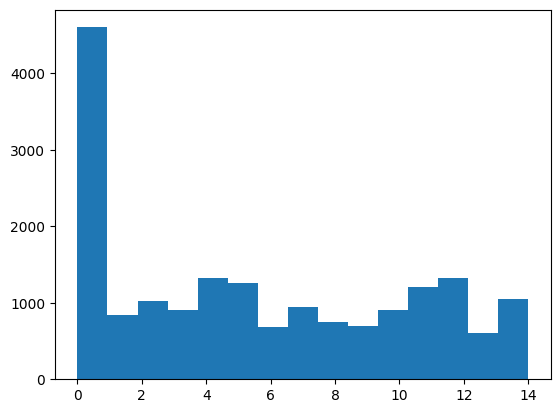

In [39]:
r = np.random.random(13)
k = np.random.random(13) * 10
r = r + k + 3
# r = sorted(r, reverse=True)

import numpy as np
ranks = [0] * 4600
for i in range(14):
    ranks+= [i+1] * int(r[i] * 100)

from matplotlib import pyplot as plt
plt.hist(ranks, bins=15)

In [ ]:
1/15